# INF-483 Text Mining: Tarea 2

Juan Pablo Muñoz, 4 de diciembre del 2018

En esta tarea se debe diseñar e implementar clasificadores de veracidad de tweets en base a sus árboles de propagación y etiqutas. Las arquitectas de los clasificadores corresponden a redes recurrentes del tipo LSTM y GRU. El input de las redes es la secuencia cronológica de retweets según lo indica el árbol de propagación, y en específico, se debe determinar la veracidad del tweet originario o raíz del árbol.

## Cargar dataset

In [90]:
import os
import pickle
import json
import re
from string import punctuation
import nltk
from nltk.tokenize import RegexpTokenizer
import collections
from gensim.models import Word2Vec
import numpy as np
from numpy.linalg import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, GRU
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

In [2]:
post_dir = 'post'

# cargar todos los json del directorio 'post' y guardarlos en un diccionario pickleable
if not os.path.isfile('posts_dict.pickle'):
    posts_dict = {}
    for file in os.listdir(post_dir):
        if file.endswith('.json'):
            with open(os.path.join(post_dir,file), 'r') as json_file:
                data = json.load(json_file)
                posts_dict[data['id_str']] = data
    with open('posts_dict.pickle', 'wb') as f:
        pickle.dump(posts_dict, f)
else:
    with open('posts_dict.pickle', 'rb') as f:
        posts_dict = pickle.load(f)
  

In [3]:
posts_dict['766808183696351233']

{'id': 766808183696351233,
 'id_str': '766808183696351233',
 'urls': [],
 'user': {'geo_enabled': True,
  'url': 'https://t.co/6UFINkGuS3',
  'favourites_count': 905016,
  'profile_sidebar_border_color': 'FFFFFF',
  'name': 'Adam',
  'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1019279174303920129/R2_FEP0S_normal.jpg',
  'created_at': 'Wed Sep 14 20:14:50 +0000 2011',
  'screen_name': 'Khanoisseur',
  'followers_count': 169183,
  'listed_count': 3066,
  'description': 'Welcome to the only 100% independent, fair + accurate news analysis feed *Turn notifications on* Podcast coming: https://t.co/XCAMicpWLM',
  'id_str': '373564351',
  'lang': 'en',
  'statuses_count': 37547,
  'profile_sidebar_fill_color': 'E6F6F9',
  'location': 'United States',
  'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme17/bg.gif',
  'profile_text_color': '333333',
  'profile_banner_url': 'https://pbs.twimg.com/profile_banners/373564351/1534978477',
  'profile_backgrou

In [4]:
len(posts_dict)

21741

In [5]:
tree_dir = 'tree'

# cargar todos los txt del directorio 'tree' y guardarlos en un diccionario pickleable
if not os.path.isfile('trees_dict.pickle'):
    trees_dict = {}
    label_dict_translation = {}
    for file in os.listdir(tree_dir):
        if file.endswith('.txt'):
            
            with open(os.path.join(tree_dir,file), 'r') as txt_file:
                try:
                    lineas = [linea.strip() for linea in txt_file]
                    # Obtener información del tweet raíz, contenida en alguna línea del archivo (no siempre la primera)
                    patron_nodo_raiz = re.compile("\['ROOT', 'ROOT', '0\.0'\]->\['(?P<root_uid>\d+)', '(?P<root_tweetid>\d+)', '(?P<root_timedelay>[-\d+.]+)'\]")
                    #print(lineas[0])
                    match_nodo_raiz = patron_nodo_raiz.search([linea_raiz for linea_raiz in lineas if 'ROOT' in linea_raiz][0]).groupdict()
                    trees_dict[match_nodo_raiz['root_tweetid']] = [
                        {
                            'uid': int(match_nodo_raiz['root_uid']),
                            'tweetid': int(match_nodo_raiz['root_tweetid']),
                            'timedelay': float(match_nodo_raiz['root_timedelay']),
                            'timedelay_delta': 0.0,
                            'tree_depth': 0,
                        }
                    ]
                    # Asociar la id del tweet raíz con el nombre del archivo txt. Éstos no siempre coinciden.
                    # La asociación es necesaria para acceder a la etiqueta de los tweets raíces
                    label_dict_translation[match_nodo_raiz['root_tweetid']] = file.strip('.txt')
                    depths = {match_nodo_raiz['root_uid']: 0}

                    # Obtener información del resto del árbol de propagación
                    patron_nodos = re.compile("\['(?P<parent_uid>\d+)', '(?P<parent_tweetid>\d+)', '(?P<parent_timedelay>[-\d+.]+)'\]->\['(?P<child_uid>\d+)', '(?P<child_tweetid>\d+)', '(?P<child_timedelay>[-\d+.]+)'\]")
                    for linea in [l for l in lineas if 'ROOT' not in l]:
                        #print(linea)
                        match_nodos = patron_nodos.search(linea).groupdict()
                        if float(match_nodos['child_timedelay']) < float(match_nodos['parent_timedelay']) or float(match_nodos['child_timedelay']) < trees_dict[match_nodo_raiz['root_tweetid']][-1]['timedelay']:
                            # El nodo padre no puede haberse producido después que el hijo.
                            # Tampoco se aceptan enlaces que rompan el orden cronológico
                            # (el nodo hijo que se intenta agregar debe ser posterior al último hijo agregado).
                            # Se elige ignorar los enlaces que no cumplan estas condiciones
                            continue

                        depths[match_nodos['child_uid']] = 1+depths[match_nodos['parent_uid']]
                        trees_dict[match_nodo_raiz['root_tweetid']].append(
                            {
                                'uid': int(match_nodos['child_uid']),
                                'tweetid': int(match_nodos['child_tweetid']),
                                'timedelay': float(match_nodos['child_timedelay']),
                                'timedelay_delta': float(match_nodos['child_timedelay'])-float(match_nodos['parent_timedelay']),
                                'tree_depth': depths[match_nodos['child_uid']],
                            }
                        )

                except Exception as e:
                    print(e)
                    print('Archivo:', file)
    with open('trees_dict.pickle', 'wb') as f:
        pickle.dump(trees_dict, f)
    with open('label_dict_translation.pickle', 'wb') as f:
        pickle.dump(label_dict_translation, f)
else:
    with open('trees_dict.pickle', 'rb') as f:
        trees_dict = pickle.load(f)
    with open('label_dict_translation.pickle', 'rb') as f:
        label_dict_translation = pickle.load(f)
  

Durante la lectura de los árboles de tweets se encontraron anormalidades en la estructura de los datos:

i. En algunas relaciones padre->hijo, el padre tenía un mayor time delay que el hijo

ii. El nodo raíz no siempre se encontraba en la primera línea

iii. A veces, las relaciones padre->hijo se repetían a la inversa en un archivo: hijo->padre, provocando la inconsistencia mencionada en i.

iv. En algunos de los casos descritos en ii., la ID del tweet raíz no coincide con su nombre de archivo

In [6]:
label_dir = 'label.txt'
if not os.path.isfile('label_dict.pickle'):
    label_dict = {}
    with open(label_dir, 'r') as txt_file:
        lineas = [linea.strip() for linea in txt_file]
        for linea in lineas:
            #print(linea)
            etiqueta, arbol_id = linea.split(':')
            label_dict[arbol_id] = etiqueta
            
    with open('label_dict.pickle', 'wb') as f:
        pickle.dump(label_dict, f)
        
else:
    with open('label_dict.pickle', 'rb') as f:
        label_dict = pickle.load(f)

## Preprocesado

#### Generar AWE de los tweets

In [8]:
# Primero se hace un corpus de todos los tweets

corpus_tweets = {tweet['id_str']: tweet['text'] for tweet in posts_dict.values()}

In [9]:
# Luego se normaliza

tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
stop_words = nltk.corpus.stopwords.words('english')
remove_terms = punctuation + '0123456789'

min_word_length = 3
min_word_freq = 3

for id_str, text in corpus_tweets.items():
    clean_tweet = [word.lower() for word in tokenizer.tokenize(re.sub(r"http\S+", "", text)) if word.lower() not in remove_terms]
    clean_tweet = [tok_sent for tok_sent in clean_tweet if tok_sent not in stop_words]
    clean_tweet = [tok_sent for tok_sent in clean_tweet if len(' '.join(tok_sent).split()) >= min_word_length]
    corpus_tweets[id_str] = clean_tweet

# Obtener frecuencias de palabras pre-limpieza
freq_tweets_pre = collections.Counter([token for id_str, text in corpus_tweets.items() for token in text])   
print('Tamaño vocabulario corpus_tweets antes:', len(freq_tweets_pre))

# última pasada para eliminar palabras poco frecuentes
for id_str, text in corpus_tweets.items():
    clean_tweet = [token for token in text if freq_tweets_pre[token] >= min_word_freq]
    corpus_tweets[id_str] = clean_tweet   

freq_tweets_post = collections.Counter([token for id_str, text in corpus_tweets.items() for token in text])   
print('Tamaño vocabulario corpus_tweets después:', len(freq_tweets_post))

Tamaño vocabulario corpus_tweets antes: 23467
Tamaño vocabulario corpus_tweets después: 6739


In [10]:
# Generar embeddings word2vec skip-gram

embedding_size = 64
window_size = 7

model_tweets = Word2Vec(corpus_tweets.values(), size=embedding_size, window=window_size, workers=2, sg=1, compute_loss=True)
model_tweets.train(corpus_tweets.values(), total_examples=len(corpus_tweets.values()), epochs=10)

(1236216, 1399620)

Chequear correctitud de creación del modelo

In [11]:
model_tweets.wv.most_similar(positive=['money'])

c:\program files\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('donated', 0.7941363453865051),
 ('payers', 0.7240647077560425),
 ('wasting', 0.7204123139381409),
 ('spending', 0.7061898708343506),
 ('vets', 0.7005283832550049),
 ('conclusion', 0.698971152305603),
 ('agrees', 0.696421205997467),
 ('spent', 0.6943320035934448),
 ('spend', 0.6905722618103027),
 ('taxes', 0.6857808232307434)]

In [12]:
model_tweets.wv['crisis']

array([ 0.5520476 , -0.49677518,  0.01220519,  0.27367938,  0.03926715,
       -0.3146453 ,  0.19809464,  0.16168739, -0.17226918, -0.38457203,
        0.10427961, -0.51626974,  0.13904493, -0.16205429,  0.13863865,
       -0.39576694, -0.29020646,  0.1543417 ,  0.29651445, -0.26312563,
        0.11518683,  0.01285347, -0.1225697 , -0.20625125,  0.23845972,
       -0.0485106 ,  0.3165818 ,  0.19405542,  0.00949448, -0.04236845,
       -0.00972586,  0.4261847 , -0.14381531,  0.6464814 , -0.02069733,
        0.20866413,  0.17726003,  0.07492452,  0.42224428, -0.31382027,
       -0.36711487,  0.13322577,  0.21229213,  0.09101961,  0.22425745,
       -0.3263243 ,  0.20743193,  0.18452732, -0.02807293,  0.39108932,
       -0.02094839, -0.20371147,  0.08099119, -0.06867534,  0.2271966 ,
       -0.16208294, -0.27656007,  0.13364634,  0.11449724, -0.05766862,
       -0.16349524, -0.1156313 , -0.14829913,  0.07819797], dtype=float32)

#### Obtener Averaged Word Embedding para tweets

In [13]:
def awe(tweet, w2v):
    d_post = [term for term in tweet if term in w2v.wv.vocab]
    #if len(list(set(doc) - set(d_post))) != 0: print('Palabras fuera del vocabulario:', list(set(doc) - set(d_post)))
    # si ninguna palabra de la consulta estaba en el vocabulario, retornar vector nulo
    if len(d_post) == 0: return np.zeros(len(w2v.wv[list(w2v.wv.vocab.keys())[0]]))
    # vector de cada término dividido en su módulo
    term_vectors = np.array([w2v.wv[term]/norm(w2v.wv[term]) for term in d_post])
    # se suman en un solo vector
    v = sum(term_vectors)
    # y se divide por la cantidad de palabras en la consulta (post eliminación de aquellas ausentes en el vocabulario)
    v = v/len(d_post)
    return v

Chequear correctitud del constructor de AWEs

In [14]:
awe(corpus_tweets['766808183696351233'], model_tweets)

array([ 0.08909552, -0.13290069, -0.11940827,  0.00064838, -0.01089293,
        0.02121803,  0.03659401,  0.07142118,  0.01692844, -0.11929207,
        0.06478176, -0.062168  ,  0.13129775, -0.04860223,  0.0387613 ,
       -0.09640284,  0.08455028, -0.11593524,  0.06137523,  0.01033543,
       -0.16913886, -0.09437016, -0.11564402,  0.04569428,  0.02699727,
       -0.14112973, -0.08842804,  0.0757557 ,  0.06100757,  0.06127399,
       -0.01095717,  0.04677238, -0.11013331,  0.03836638,  0.03736732,
        0.02773708,  0.16451725, -0.22038138,  0.10794064,  0.10479577,
       -0.10772649,  0.02831705,  0.04131611,  0.08466413, -0.19779119,
       -0.0082314 ,  0.08440441,  0.2659394 , -0.04554609,  0.12320391,
        0.06694798,  0.03107649,  0.04805129,  0.13545509,  0.11274598,
       -0.05913721,  0.02250089,  0.10497244,  0.08815767,  0.17004728,
        0.00447999, -0.08284148,  0.08614092, -0.016386  ], dtype=float32)

#### One-hot encoding de etiquetas de tweets

In [15]:
labels = list(label_dict.values())
labels = np.array(labels)
int_label_encoder = LabelEncoder()
int_label_encoder.fit(labels)
label_dict = {k: int_label_encoder.transform([v]) for k, v in label_dict.items()}

int_labels = list(label_dict.values())
int_labels = np.array(int_labels)

onehot_label_encoder = OneHotEncoder(sparse=False)
onehot_label_encoder.fit(int_labels)
label_dict = {k: onehot_label_encoder.transform([v])[0] for k, v in label_dict.items()}

c:\program files\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


#### Transformador one-hot -> etiqueta

In [16]:
def inverse_transform(onehot_vector, onehot_encoder, label_encoder):
    int_label = int(onehot_encoder.inverse_transform([onehot_vector])[0])
    true_label = label_encoder.inverse_transform([int_label])[0]
    return true_label
    
inverse_transform(label_dict['656955120626880512'], onehot_label_encoder, int_label_encoder)

'false'

## Generar ejemplos de entrenamiento

Para cada $tweet_i$ en un árbol de propagación, el input $x_i$ está definido como

\begin{align}
x_i = concat(AWE(tweet_i), timeDelta(tweet_i), treeDepth(tweet_i))
\end{align}

Donde $timeDelta(tweet_i)=timeDelay(tweet_i)-timeDelay(parentOf(tweet_i))$ y $treeDepth(tweet_i)$ es la profundidad de $tweet_i$ en el árbol de propagación.

In [17]:
num_retweets=0
num_missing_tweets = 0

X_sin_padding = []
Y = []
for tweet_id, arbol in trees_dict.items():
    if tweet_id not in posts_dict:
        num_retweets+=1
        print('tweet ID='+tweet_id+' no encontrado en posts -> es retweet')
        continue
    else:
        arbol_preparado = []
        for nodo in arbol:
            if str(nodo['tweetid']) not in corpus_tweets:
                num_missing_tweets += 1
                #print(str(nodo['tweetid'])+' no encontrado en corpus_tweets')
                continue
            awe_tweet = awe(corpus_tweets[str(nodo['tweetid'])], model_tweets)
            timedelta_tweet = nodo['timedelay_delta']
            treedepth_tweet = nodo['tree_depth']
            nodo_preparado = np.concatenate((awe_tweet, [timedelta_tweet], [treedepth_tweet]))
            arbol_preparado.append(nodo_preparado)
        X_sin_padding.append(arbol_preparado)
        Y.append(label_dict[label_dict_translation[tweet_id]])
print('Total Retweets:', num_retweets)
print('Total Tweets no encontrados:', num_missing_tweets)

num_categorias = len(onehot_label_encoder.get_feature_names())
num_atributos = embedding_size+2
num_arboles = len(X_sin_padding)
size_mayor_arbol = max([len(a) for a in X_sin_padding])


print('num_categorias='+str(num_categorias)+', num_atributos='+str(num_atributos)+', num_arboles='+str(num_arboles)+', size_mayor_arbol='+str(size_mayor_arbol))

tweet ID=524922729485848576 no encontrado en posts -> es retweet
tweet ID=524931324763992064 no encontrado en posts -> es retweet
tweet ID=524947674164760577 no encontrado en posts -> es retweet
tweet ID=525019752507658240 no encontrado en posts -> es retweet
tweet ID=525025279803424768 no encontrado en posts -> es retweet
tweet ID=525058976376193024 no encontrado en posts -> es retweet
tweet ID=544271284796784640 no encontrado en posts -> es retweet
tweet ID=544289311504355328 no encontrado en posts -> es retweet
tweet ID=544291804057960448 no encontrado en posts -> es retweet
tweet ID=544319274072817664 no encontrado en posts -> es retweet
tweet ID=553221600955621376 no encontrado en posts -> es retweet
tweet ID=553543369604210689 no encontrado en posts -> es retweet
tweet ID=604625816992002049 no encontrado en posts -> es retweet
tweet ID=614054616154550273 no encontrado en posts -> es retweet
tweet ID=614467824313106432 no encontrado en posts -> es retweet
tweet ID=6144941705903677

#### Hacer padding de ceros para X

In [18]:
size_arboles = sorted([len(a) for a in X_sin_padding], reverse=True)
for i in [500, 1000, 2000, 3000]:
    cantidad = len([a for a in size_arboles if a > i])
    porcentaje = round(100*cantidad/len(size_arboles), 1)
    print('Truncando a un máximo de {} nodos, {} árbol(es) ({}% del total) se vería(n) afectado(s)'.format(i, cantidad, porcentaje))

Truncando a un máximo de 500 nodos, 177 árbol(es) (23.6% del total) se vería(n) afectado(s)
Truncando a un máximo de 1000 nodos, 59 árbol(es) (7.9% del total) se vería(n) afectado(s)
Truncando a un máximo de 2000 nodos, 15 árbol(es) (2.0% del total) se vería(n) afectado(s)
Truncando a un máximo de 3000 nodos, 1 árbol(es) (0.1% del total) se vería(n) afectado(s)


In [19]:
# Hacer padding para X y truncar

max_tree_size = 500

nodo_vacio = np.zeros(num_atributos).astype(np.float32)

X = []
for arbol in X_sin_padding:
    if len(arbol) <= max_tree_size:
        x_padded = np.concatenate((arbol, np.repeat([nodo_vacio], [max_tree_size-len(arbol)], axis=0)))
        X.append(x_padded)
    else:
        x_padded = arbol[:max_tree_size]
        X.append(x_padded)
X = np.array(X)

In [20]:
X.shape

(751, 500, 66)

## Definición y entrenamiento de modelos RNN

#### Arquitectura LSTM

In [21]:
def get_lstm():
    model = Sequential()
    model.add(LSTM(int(max_tree_size/1), input_shape=(max_tree_size, num_atributos)))
    model.add(Dropout(0.30))
    model.add(Dense(num_categorias))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
get_lstm().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 500)               1134000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2004      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 1,136,004
Trainable params: 1,136,004
Non-trainable params: 0
_________________________________________________________________


In [72]:
def get_f1_score(Y_true, Y_pred):
    categorical_Y_true = [int(i) for i in onehot_label_encoder.inverse_transform(Y_true)]
    categorical_Y_pred = [np.argmax(i) for i in Y_pred]
    result = f1_score(categorical_Y_true, categorical_Y_pred, average=None)
    return {int_label_encoder.inverse_transform([i])[0]: result[i] for i in range(len(result))}

def get_f1_score_weighted(Y_true, Y_pred):
    categorical_Y_true = [int(i) for i in onehot_label_encoder.inverse_transform(Y_true)]
    categorical_Y_pred = [np.argmax(i) for i in Y_pred]
    result = f1_score(categorical_Y_true, categorical_Y_pred, average='weighted')
    return result
    
def get_confusion_matrix(Y_true, Y_pred):
    categorical_Y_true = list(int_label_encoder.inverse_transform([int(i) for i in onehot_label_encoder.inverse_transform(Y_true)]))
    categorical_Y_pred = list(int_label_encoder.inverse_transform([np.argmax(i) for i in Y_pred]))
    result = confusion_matrix(categorical_Y_true, categorical_Y_pred, labels=list(int_label_encoder.classes_))
    return result

def entrenar_lstm():
    loss = []
    accuracy = []
    f1_score = []
    f1_score_weighted = []
    confusion_matrix = []
    k=5
    categorical_Y = [int(i) for i in onehot_label_encoder.inverse_transform(Y)]
    folds = StratifiedKFold(n_splits=k).split(X, categorical_Y)
    
    for i, (train_indexes, test_indexes) in enumerate(folds): 
        print('Fold:', str(i+1))
        X_train = X[train_indexes]
        Y_train = np.array(Y)[train_indexes]
        X_test = X[test_indexes]
        Y_test = np.array(Y)[test_indexes]
        
        modelo_lstm = get_lstm()
        modelo_lstm.fit(X_train, Y_train, batch_size=32, epochs=1, validation_data=(X_test, Y_test))
        
        result = modelo_lstm.evaluate(X_test, Y_test)
        loss.append(result[0])
        print('Loss:', round(loss[-1], 3))
        accuracy.append(result[1])
        print('Accuracy:', round(accuracy[-1], 3))
        #f1_score.append(get_f1_score(Y_test, modelo_lstm.predict(X_test)))
        #print('F1-Score:', f1_score[-1])
        f1_score_weighted.append(get_f1_score_weighted(Y_test, modelo_lstm.predict(X_test)))
        print('F1-Score (weighted):', round(f1_score_weighted[-1], 3))
        confusion_matrix.append(get_confusion_matrix(Y_test, modelo_lstm.predict(X_test)))
        print('Confusion Matrix:\n', confusion_matrix[-1])
        
    return {'loss': loss, 'accuracy': accuracy, 'f1_score_weighted':f1_score_weighted, 'confusion_matrix': confusion_matrix}
    #return {'loss': loss, 'accuracy': accuracy, 'f1_score': f1_score, 'f1_score_micro':f1_scrore_micro, 'confusion_matrix': confusion_matrix}

In [34]:
# batch_size = 84
resultados_lstm_1 = entrenar_lstm()

Fold: 1
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 12ms/step
Loss: 1.403
Accuracy: 0.318
F1-Score (weighted): 0.255
Confusion Matrix:
 [[ 1  5  1 29]
 [ 1 13  3 24]
 [ 0  3  4 31]
 [ 0  6  0 30]]
Fold: 2
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 12ms/step
Loss: 1.404
Accuracy: 0.305


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score (weighted): 0.216
Confusion Matrix:
 [[ 0  6  0 30]
 [ 0 16  0 25]
 [ 1  2  0 35]
 [ 1  5  0 30]]
Fold: 3
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 12ms/step
Loss: 1.301
Accuracy: 0.358


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score (weighted): 0.289
Confusion Matrix:
 [[ 0  1  4 31]
 [ 0 17  0 24]
 [ 0  2  4 32]
 [ 0  3  0 33]]
Fold: 4
Train on 601 samples, validate on 150 samples
Epoch 1/1
150/150 [==============================] - 2s 12ms/step
Loss: 1.319
Accuracy: 0.367
F1-Score (weighted): 0.305
Confusion Matrix:
 [[ 0  2  2 32]
 [ 2 15  1 23]
 [ 1  6  7 23]
 [ 1  2  0 33]]
Fold: 5
Train on 603 samples, validate on 148 samples
Epoch 1/1
148/148 [==============================] - 2s 12ms/step
Loss: 1.363
Accuracy: 0.392
F1-Score (weighted): 0.3
Confusion Matrix:
 [[ 0  5  0 31]
 [ 2 27  8  3]
 [ 1  9  1 26]
 [ 2  2  1 30]]


In [73]:
# batch_size = 32
resultados_lstm_2 = entrenar_lstm()

Fold: 1
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 13ms/step
Loss: 1.388
Accuracy: 0.311
F1-Score (weighted): 0.231
Confusion Matrix:
 [[ 1  5  0 30]
 [ 2 15  0 24]
 [ 0  6  1 31]
 [ 0  6  0 30]]
Fold: 2
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 13ms/step
Loss: 1.415
Accuracy: 0.285
F1-Score (weighted): 0.204
Confusion Matrix:
 [[ 0  4  2 30]
 [ 1 11  4 25]
 [ 0  1  1 36]
 [ 0  3  2 31]]
Fold: 3
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 13ms/step
Loss: 1.372
Accuracy: 0.272


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score (weighted): 0.159
Confusion Matrix:
 [[ 0 35  1  0]
 [ 0 36  5  0]
 [ 0 33  5  0]
 [ 0 36  0  0]]
Fold: 4
Train on 601 samples, validate on 150 samples
Epoch 1/1
150/150 [==============================] - 2s 13ms/step
Loss: 1.327
Accuracy: 0.347
F1-Score (weighted): 0.278
Confusion Matrix:
 [[ 0  2  2 32]
 [ 4 13  0 24]
 [ 3  6  5 23]
 [ 1  1  0 34]]
Fold: 5
Train on 603 samples, validate on 148 samples
Epoch 1/1
148/148 [==============================] - 2s 13ms/step
Loss: 1.335
Accuracy: 0.399
F1-Score (weighted): 0.304
Confusion Matrix:
 [[ 0  5  0 31]
 [ 4 27  6  3]
 [ 1  9  1 26]
 [ 2  2  0 31]]


In [79]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, cmap='summer', normalize=False):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt = '.2f' if normalize else 'd', cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

def resumen_resultado(resultado_dict, cmap='summer'):
    mean_loss = round(np.mean(resultado_dict['loss']), 3)
    mean_acc = round(np.mean(resultado_dict['accuracy']), 3)
    mean_f1 = round(np.mean(resultado_dict['f1_score_weighted']), 3)
    accumulated_confusion_matrix = sum(resultado_dict['confusion_matrix'])
    mean_normalized_confusion_matrix = np.round(sum(resultado_dict['confusion_matrix'])/np.max(sum(resultado_dict['confusion_matrix'])), 3)
    print('Resultado entrenamiento de la RNN con 5-Fold Validation\n')
    print('Loss promedio =', mean_loss)
    print('Accuracy promedio =', mean_acc)
    print('F1-Score (weighted) promedio =', mean_f1)
    
    print_confusion_matrix(accumulated_confusion_matrix, list(int_label_encoder.classes_), cmap=cmap, normalize=True).show()
    

Resultado entrenamiento de la RNN con 5-Fold Validation

Loss promedio = 1.358
Accuracy promedio = 0.348
F1-Score (weighted) promedio = 0.273
Normalized confusion matrix


c:\program files\python36\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


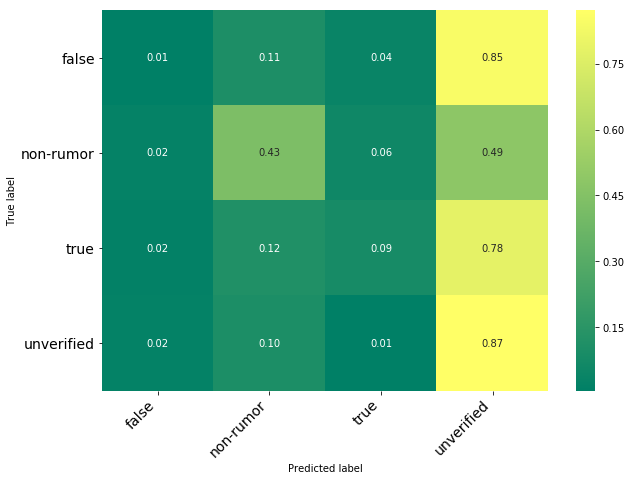

In [77]:
resumen_resultado(resultados_lstm_1)

Resultado entrenamiento de la RNN con 5-Fold Validation

Loss promedio = 1.367
Accuracy promedio = 0.323
F1-Score (weighted) promedio = 0.235
Normalized confusion matrix


c:\program files\python36\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


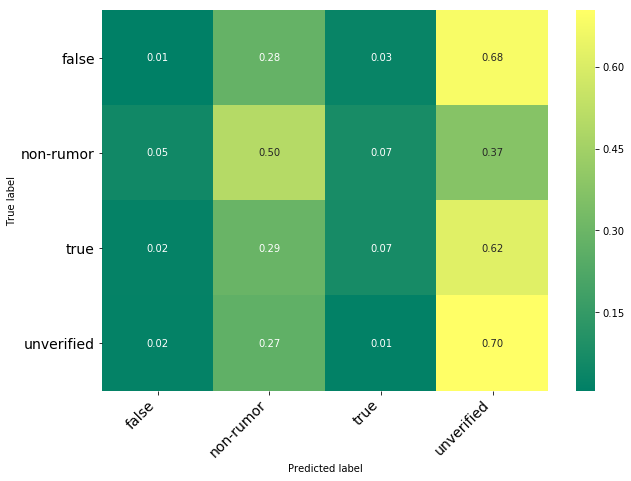

In [78]:
resumen_resultado(resultados_lstm_2)

El mejor resultado logrado con LSTMs se observa arriba. El accuracy promedio de los 5 folds llega al $34.8\%$ cuando se entrena usando un ```batch_size=84```, superando levemente al $32.3\%$ cuando se entrena usando un ```batch_size=32```. En ambos casos se observa una muy marcada tendencia a predecir ```unverified``` y ```non-rumor```, siendo la segunda opción más marcada en la segunda LSTM.

In [91]:
labels = [inverse_transform(e, onehot_label_encoder, int_label_encoder) for e in label_dict.values()]
labels_counter = collections.Counter(labels)
labels_counter

Counter({'false': 205, 'true': 207, 'unverified': 201, 'non-rumor': 205})

#### Arquitectura GRU

In [38]:
def get_gru():
    model = Sequential()
    model.add(GRU(int(max_tree_size/1), input_shape=(max_tree_size, num_atributos)))
    model.add(Dropout(0.30))
    model.add(Dense(num_categorias))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [39]:
get_gru().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 500)               850500    
_________________________________________________________________
dropout_27 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 2004      
_________________________________________________________________
activation_27 (Activation)   (None, 4)                 0         
Total params: 852,504
Trainable params: 852,504
Non-trainable params: 0
_________________________________________________________________


In [42]:
def get_f1_score(Y_true, Y_pred):
    categorical_Y_true = [int(i) for i in onehot_label_encoder.inverse_transform(Y_true)]
    categorical_Y_pred = [np.argmax(i) for i in Y_pred]
    result = f1_score(categorical_Y_true, categorical_Y_pred, average=None)
    return {int_label_encoder.inverse_transform([i])[0]: result[i] for i in range(len(result))}

def get_f1_score_weighted(Y_true, Y_pred):
    categorical_Y_true = [int(i) for i in onehot_label_encoder.inverse_transform(Y_true)]
    categorical_Y_pred = [np.argmax(i) for i in Y_pred]
    result = f1_score(categorical_Y_true, categorical_Y_pred, average='weighted')
    return result
    
def get_confusion_matrix(Y_true, Y_pred):
    categorical_Y_true = list(int_label_encoder.inverse_transform([int(i) for i in onehot_label_encoder.inverse_transform(Y_true)]))
    categorical_Y_pred = list(int_label_encoder.inverse_transform([np.argmax(i) for i in Y_pred]))
    result = confusion_matrix(categorical_Y_true, categorical_Y_pred, labels=list(int_label_encoder.classes_))
    return result

def entrenar_gru():
    loss = []
    accuracy = []
    f1_score = []
    f1_score_weighted = []
    confusion_matrix = []
    k=5
    categorical_Y = [int(i) for i in onehot_label_encoder.inverse_transform(Y)]
    folds = StratifiedKFold(n_splits=k).split(X, categorical_Y)
    
    for i, (train_indexes, test_indexes) in enumerate(folds): 
        print('Fold:', str(i+1))
        X_train = X[train_indexes]
        Y_train = np.array(Y)[train_indexes]
        X_test = X[test_indexes]
        Y_test = np.array(Y)[test_indexes]
        
        modelo_gru = get_gru()
        modelo_gru.fit(X_train, Y_train, batch_size=32, epochs=1, validation_data=(X_test, Y_test))
        
        result = modelo_gru.evaluate(X_test, Y_test)
        loss.append(result[0])
        print('Loss:', round(loss[-1], 3))
        accuracy.append(result[1])
        print('Accuracy:', round(accuracy[-1], 3))
        #f1_score.append(get_f1_score(Y_test, modelo_gru.predict(X_test)))
        #print('F1-Score:', f1_score[-1])
        f1_score_weighted.append(get_f1_score_weighted(Y_test, modelo_gru.predict(X_test)))
        print('F1-Score (weighted):', round(f1_score_weighted[-1], 3))
        confusion_matrix.append(get_confusion_matrix(Y_test, modelo_gru.predict(X_test)))
        print('Confusion Matrix:\n', confusion_matrix[-1])
        
    return {'loss': loss, 'accuracy': accuracy, 'f1_score_weighted':f1_score_weighted, 'confusion_matrix': confusion_matrix}
    #return {'loss': loss, 'accuracy': accuracy, 'f1_score': f1_score, 'f1_score_micro':f1_scrore_micro, 'confusion_matrix': confusion_matrix}

In [43]:
# batch_size = 64
resultados_gru_1 = entrenar_gru()

Fold: 1
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 11ms/step
Loss: 1.47
Accuracy: 0.285


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score (weighted): 0.215
Confusion Matrix:
 [[ 0  1  4 31]
 [ 0  8  7 26]
 [ 0  2  5 31]
 [ 0  5  1 30]]
Fold: 2
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 11ms/step
Loss: 1.386
Accuracy: 0.298


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score (weighted): 0.208
Confusion Matrix:
 [[30  6  0  0]
 [26 15  0  0]
 [36  2  0  0]
 [31  5  0  0]]
Fold: 3
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 11ms/step
Loss: 1.316
Accuracy: 0.325
F1-Score (weighted): 0.245
Confusion Matrix:
 [[ 0  2 34  0]
 [ 1 16 24  0]
 [ 0  6 32  0]
 [ 1  1 33  1]]
Fold: 4
Train on 601 samples, validate on 150 samples
Epoch 1/1
150/150 [==============================] - 2s 11ms/step
Loss: 1.543
Accuracy: 0.327


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score (weighted): 0.217
Confusion Matrix:
 [[ 0  4  0 32]
 [ 0 15  0 26]
 [ 0 13  0 24]
 [ 0  2  0 34]]
Fold: 5
Train on 603 samples, validate on 148 samples
Epoch 1/1
148/148 [==============================] - 2s 11ms/step
Loss: 1.309
Accuracy: 0.399
F1-Score (weighted): 0.3
Confusion Matrix:
 [[ 0  3  0 33]
 [ 0 24  7  9]
 [ 1  8  1 27]
 [ 0  0  1 34]]


In [44]:
# batch_size = 32
resultados_gru_2 = entrenar_gru()

Fold: 1
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 11ms/step
Loss: 1.399
Accuracy: 0.325


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score (weighted): 0.248
Confusion Matrix:
 [[31  5  0  0]
 [26 15  0  0]
 [31  4  3  0]
 [30  6  0  0]]
Fold: 2
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 11ms/step
Loss: 1.366
Accuracy: 0.291
F1-Score (weighted): 0.23
Confusion Matrix:
 [[30  1  1  4]
 [26 11  3  1]
 [36  1  1  0]
 [31  2  1  2]]
Fold: 3
Train on 600 samples, validate on 151 samples
Epoch 1/1
151/151 [==============================] - 2s 11ms/step
Loss: 1.307
Accuracy: 0.325


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score (weighted): 0.221
Confusion Matrix:
 [[ 0  2  0 34]
 [ 0 14  0 27]
 [ 0  6  0 32]
 [ 0  1  0 35]]
Fold: 4
Train on 601 samples, validate on 150 samples
Epoch 1/1
150/150 [==============================] - 2s 11ms/step
Loss: 1.379
Accuracy: 0.313


c:\program files\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score (weighted): 0.218
Confusion Matrix:
 [[32  4  0  0]
 [27 14  0  0]
 [24 13  0  0]
 [34  1  0  1]]
Fold: 5
Train on 603 samples, validate on 148 samples
Epoch 1/1
148/148 [==============================] - 2s 12ms/step
Loss: 1.411
Accuracy: 0.372
F1-Score (weighted): 0.304
Confusion Matrix:
 [[ 0  3 31  2]
 [ 2 26  8  4]
 [ 0  8 27  2]
 [ 1  0 32  2]]


Resultado entrenamiento de la RNN con 5-Fold Validation

Loss promedio = 1.405
Accuracy promedio = 0.327
F1-Score (weighted) promedio = 0.237
Normalized confusion matrix


c:\program files\python36\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


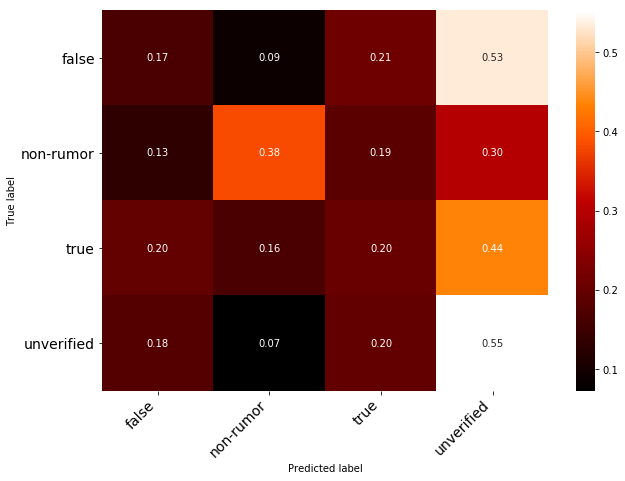

In [81]:
resumen_resultado(resultados_gru_1, cmap='gist_heat')

Resultado entrenamiento de la RNN con 5-Fold Validation

Loss promedio = 1.373
Accuracy promedio = 0.325
F1-Score (weighted) promedio = 0.244
Normalized confusion matrix


c:\program files\python36\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


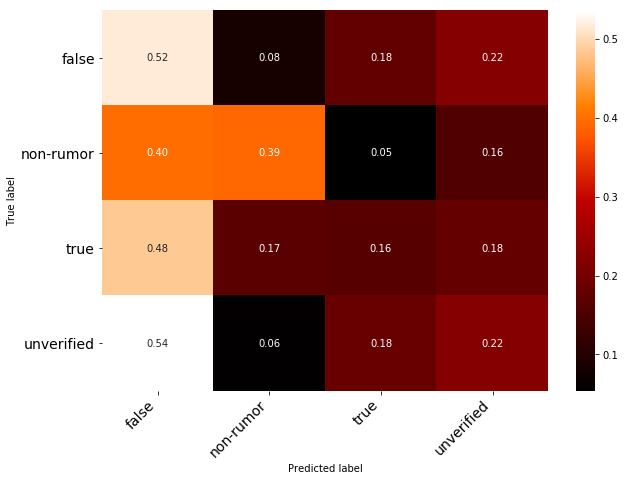

In [82]:
resumen_resultado(resultados_gru_2, cmap='gist_heat')

De igual manera, los dos casos de GRU mostrados corresponden a los mejores encontrados. El primer resultado corresponde a una GRU entrenada usando ```batch_size=64``` y alcanzó un accuracy de $32.7\%$. El rendimiento es prácticamente igual que al entrenar con ```batch_size=32```, lo que dio $32.5\%$ de accuracy.

Las GRU también muestran el sesgo de las LSTMs en la predicción, pero se observa que en general la probabilidad está más distribuida entre las posibles predicciones. En la primera GRU, el sesgo está por clasificar como ```unverified```, mientras que en la segunda, en clasificar como ```false```.